In [13]:
# Importing the Necessary Libraries
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from tensorflow.keras.layers import concatenate
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [2]:
# Connecting to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Defining the Training and Test Path
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

In [ ]:
# Checking the Number of Folders/Classes (Normal and Pneumonia)
folders = glob('/content/drive/MyDrive/Dataset/train/*')
print(len(folders))

2


In [ ]:
# The Settings for Generating the Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [9]:
# The Settings for Generating the Test Set  
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
# Generating the Training Set 
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=32,
                                                 class_mode = 'categorical')

Found 4686 images belonging to 2 classes.


In [ ]:
# Generating the Test Set 
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=32,
                                            class_mode = 'categorical')

Found 1170 images belonging to 2 classes.


In [ ]:
# Defining the Input Shape
input_tensor=Input(shape=(224,224,3))

In [ ]:
# Importing Model 1 (VGG16)
base_model1 = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
# Extracting the Features
features1 = base_model1.output
for layer in base_model1.layers: 
  layer.trainable=True  # All layers are trainble
for layer in base_model1.layers:  
  layer._name = layer._name + str('_C') # Because the names of some layers are the same in 
                                        # both networks, a letter is assigned to prevent error

In [ ]:
# Importing the Model 2 (VGG16)
base_model2 = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
# Extracting the Features
features2 = base_model2.output
for layer in base_model2.layers:
  layer.trainable=True # All layers are trainble
for layer in base_model2.layers:  
  layer._name = layer._name + str('_D') # Because the names of some layers are the same in 
                                        # both networks, a letter is assigned to prevent error

In [ ]:
# Concatenating the Features
concatenated=concatenate([features1,features2]) 

In [ ]:
# Creating FC Layers
x = Flatten(name='flatten')(concatenated)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)
x = Dense(len(folders), activation='softmax', name='predictions')(x)

In [ ]:
# Creating the Final Hybrid CNN Model
Concatenated_model = Model(inputs=input_tensor, outputs=x)

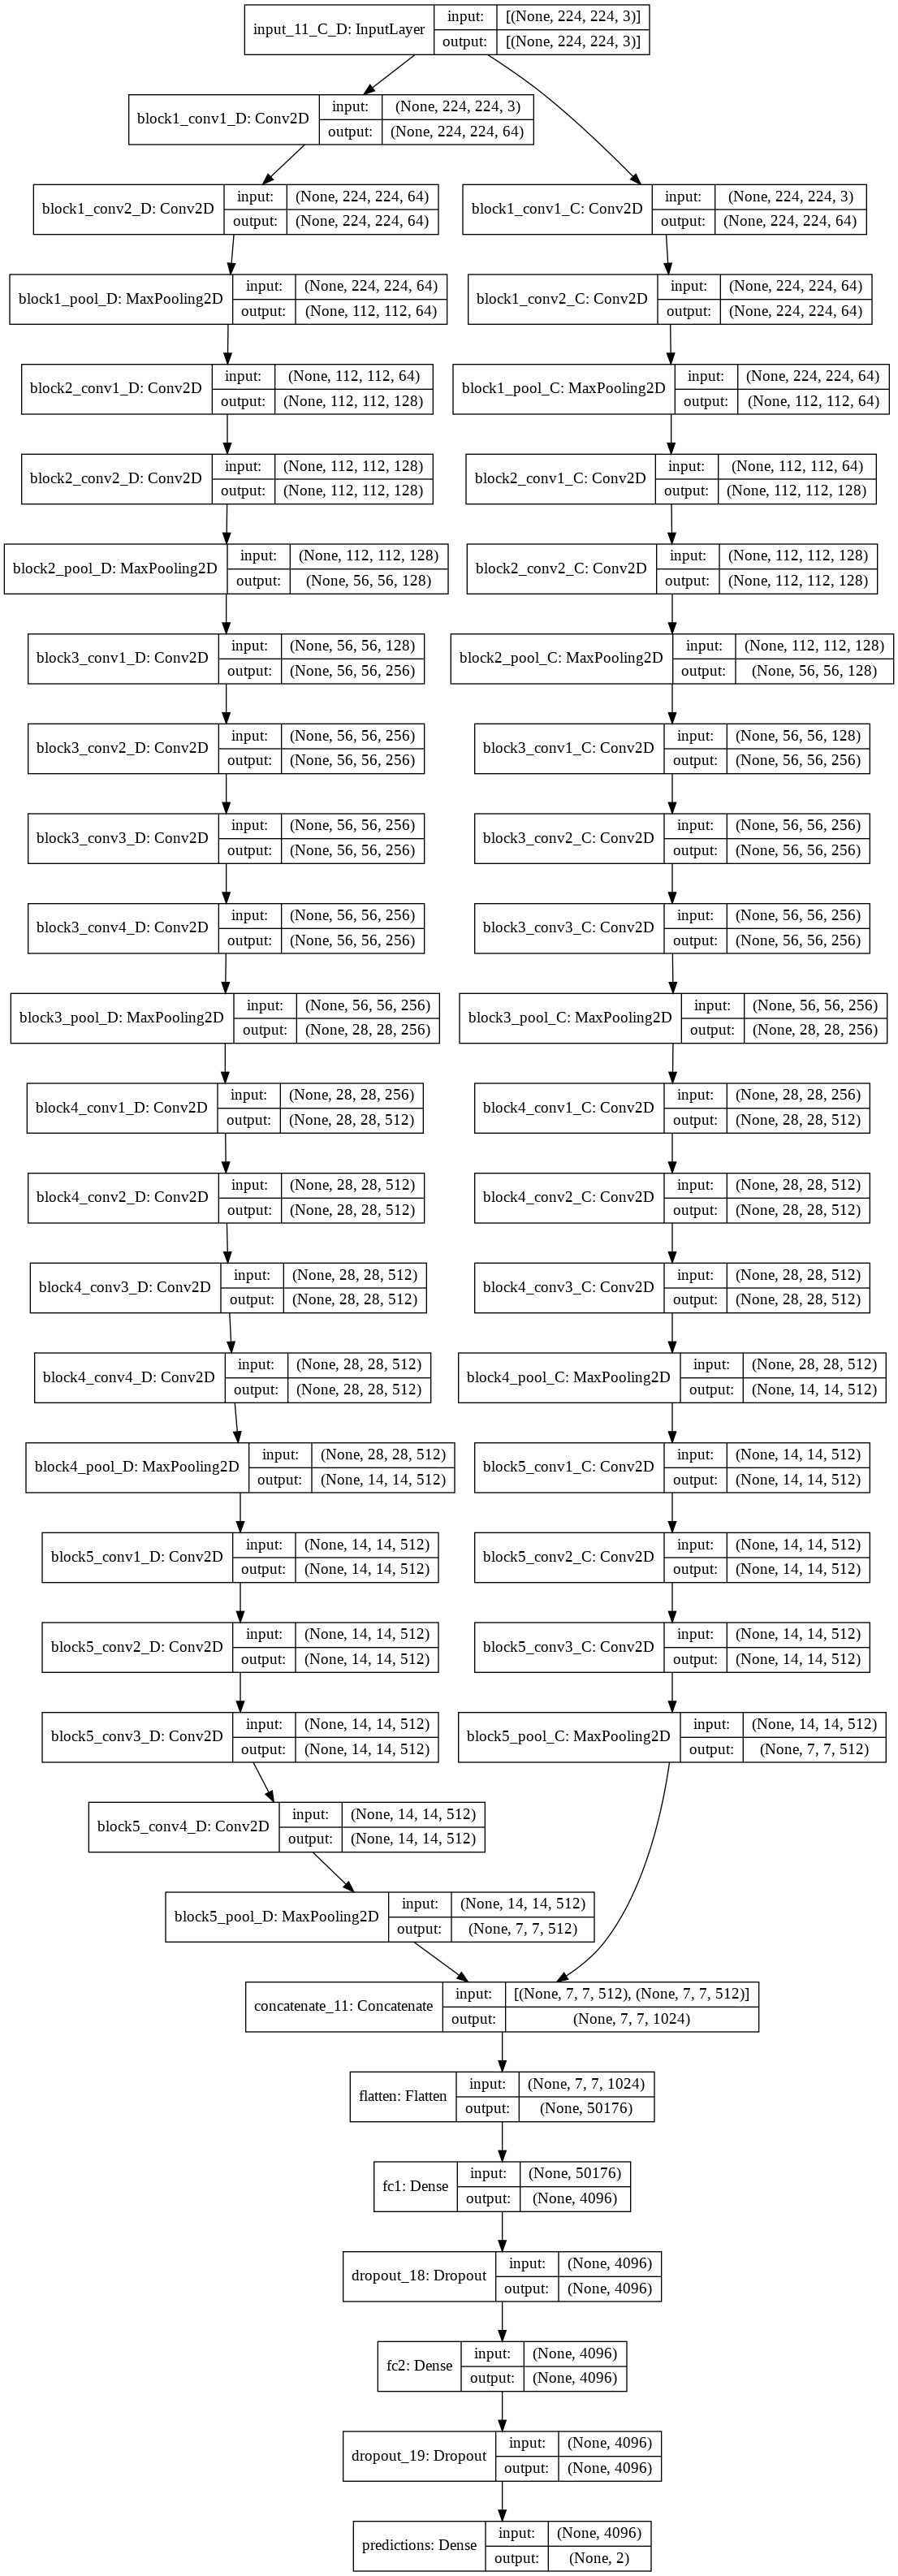

In [ ]:
# Showing the Architecture of the Hybrid Model
from tensorflow.keras.utils import plot_model
plot_model(Concatenated_model, show_shapes=True)

In [ ]:
# Checking the Model Components
Concatenated_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11_C_D (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_D (Conv2D)         (None, 224, 224, 64) 1792        input_11_C_D[0][0]               
__________________________________________________________________________________________________
block1_conv2_D (Conv2D)         (None, 224, 224, 64) 36928       block1_conv1_D[0][0]             
__________________________________________________________________________________________________
block1_pool_D (MaxPooling2D)    (None, 112, 112, 64) 0           block1_conv2_D[0][0]             
____________________________________________________________________________________________

In [ ]:
# Setting the Weight Optimizer and Loss Function
sgd = optimizers.SGD()
Concatenated_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# Saving the Weight Parameters, When Achieving a Higher Test Accuracy
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ChestVGG_SGD.h5', 
                               monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

# Training the Hybrid Model
Concatenated_model_history=Concatenated_model.fit(
    train_set,
  validation_data=test_set,
  epochs=20,
    callbacks=callbacks ,verbose=1)

duration = datetime.now() - start
print("Training time: ", duration)

Epoch 1/20
147/147 [==============================] - 295s 2s/step - loss: 0.4477 - accuracy: 0.8015 - val_loss: 0.2409 - val_accuracy: 0.9188

Epoch 00001: val_accuracy improved from -inf to 0.91880, saving model to /content/drive/MyDrive/ChestVGG_SGD.h5
Epoch 2/20
147/147 [==============================] - 290s 2s/step - loss: 0.2189 - accuracy: 0.9108 - val_loss: 0.1443 - val_accuracy: 0.9393

Epoch 00002: val_accuracy improved from 0.91880 to 0.93932, saving model to /content/drive/MyDrive/ChestVGG_SGD.h5
Epoch 3/20
147/147 [==============================] - 290s 2s/step - loss: 0.2167 - accuracy: 0.9159 - val_loss: 0.1265 - val_accuracy: 0.9487

Epoch 00003: val_accuracy improved from 0.93932 to 0.94872, saving model to /content/drive/MyDrive/ChestVGG_SGD.h5
Epoch 4/20
147/147 [==============================] - 290s 2s/step - loss: 0.1580 - accuracy: 0.9381 - val_loss: 0.3235 - val_accuracy: 0.8581

Epoch 00004: val_accuracy did not improve from 0.94872
Epoch 5/20
147/147 [=======

In [4]:
# Loading the Saved Model
network = load_model('/content/drive/MyDrive/ChestVGG_SGD.h5')

In [10]:
# Creating Evaluation Set and Evaluating the Model
test_set_evaluation = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode = 'categorical')
network.evaluate(test_set_evaluation, steps=1170)

Found 1170 images belonging to 2 classes.
1170/1170 [==============================] - 282s 233ms/step - loss: 0.0579 - accuracy: 0.9795


[0.05792677775025368, 0.9794871807098389]

In [16]:
# Making Predictions
predictions=network.predict(test_set_evaluation, steps=1170, verbose=1)
preds=np.argmax(predictions, axis=1)

1170/1170 [==============================] - 128s 109ms/step


0.9794871794871794

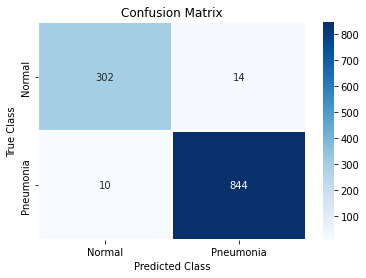

In [20]:
# Creating the Confusion Matrix
cf_matrix=confusion_matrix(test_set_evaluation.classes, preds)
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
accuracy_score(test_set_evaluation.classes, preds)